# Spectrum of the transverse field Ising model with matrix product state methods

The Hamiltonian of the transverse field Ising (TFI) model reads

$$ H = -J \sum_n \sigma^x_n \sigma^x_{n+1} - g \sum_n \sigma^z_n \overset{J=1}{=} -\sum_n \sigma^x_n \sigma^x_{n+1} - g \sum_n \sigma^z_n. $$

* $\mathbb{Z}_2-\mathrm{symmetry}$: $[H, U] = 0$ with $U = \prod\limits_n \sigma^z_n$,
* Magnetization: $\langle \sigma^x \rangle = \frac{1}{N}\sum\limits_{n=1}^N \langle \sigma^x_n \rangle = \sqrt{\lim\limits_{\vert n-m \vert \to \infty} \langle \sigma^x_n\sigma^x_m \rangle}$.

From connecting the two limits of the transverse field $g$, we expect the following quantum phase diagram:

* Ferromagnetic phase $g < g_c$
	* two degenerate, symmetry broken ground states related by $U$ ($\ket{...\rightarrow\rightarrow\rightarrow...}$ and $\ket{...\leftarrow\leftarrow\leftarrow...}$ for $g = 0$)
	* $\langle \sigma^x \rangle = \pm m \neq 0$ ($m = 1$ for $g = 0$)
	* elementary excitations: topological domain walls ($\ket{...\rightarrow\rightarrow\rightarrow \leftarrow\leftarrow\leftarrow...}$ for $g = 0$)

* Paramagnetic phase $g > g_c$
	* unique symmetric ground state ($\ket{...\uparrow\uparrow\uparrow...}$ for $g \to \infty$)
	* $\langle \sigma^x \rangle = 0$
	* elementary excitations: single spin flips ($\ket{...\uparrow\uparrow \downarrow \uparrow\uparrow...}$ for $g \to \infty$)

* Quantum phase transition at $g_c$


By performing Jordan-Wigner, Fourier and Bogoliubov transformations, the TFI model with peridic boundary conditions can be diagonalized analytically. The Hamiltonian in terms of fermionic creation and annihilation operators $\gamma_{p}^{\dagger}$ and $\gamma_{p}$ reads

$$H = \sum_{p} \epsilon_p \gamma_{p}^{\dagger}\gamma_{p} + E_0.$$

Single particle excitation energy: $\epsilon_p = 2 \sqrt{1 - 2g\cos(p) + g^2}$ $\Rightarrow$ energy gap closes at quantum critical point $g_c = 1$.

Ground state energy: $E_0 = -\sum_{p} \epsilon_p/2$ $\Rightarrow$ ground state energy density in the thermodynamic limit: $e_0 = - \frac{1}{2\pi} \int_{-\pi}^{\pi} \epsilon_p/2$.

(For details see Subir Sachdev, Quantum Phase Transitions, 2nd ed, Cambridge University Press, 2011)

In [1]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

from a_umps import UniformMPS
from b_model_infinite import TFIModelInfinite
from c_vumps import vumps_algorithm
from d_uexcitations import VariationalPlaneWaveExcitationEngine

from a_mps import MPS
from b_model_finite import TFIModelFinite
from c_dmrg import dmrg_algorithm
from d_excitations import VariationalQuasiparticleExcitationEngine, \
                          get_translation_overlap, get_emps_translation_overlap

## 1) Ground state

### 1.1) Infinite uniform MPS: VUMPS

In [2]:
def get_infinite_tfi_gs(g, D):
    """For the TFI model on an infinite chain with transverse field g, find the ground state with 
    VUMPS using a bond dimension D."""
    print(f"g = {g}, D = {D}:")
    tfi_model_infinite = TFIModelInfinite(g)
    h = tfi_model_infinite.get_h()
    guess_umps0 = UniformMPS.from_desired_bond_dimension(D)
    e0, umps0, var0 = vumps_algorithm(h, guess_umps0, tol=1.e-10)
    e0_exact = tfi_model_infinite.get_exact_gs_energy_density()
    print(f"|e0 - e0_exact| = {np.abs(e0-e0_exact)}.")
    mx0 = umps0.get_site_expectation_value(tfi_model_infinite.sigma_x)
    mz0 = umps0.get_site_expectation_value(tfi_model_infinite.sigma_z)
    print(f"Magnetization densities: {mx0} (X) and {mz0} (Z).")
    return e0, umps0, mx0

### 1.2) Finite MPS: DMRG

In [3]:
def get_finite_tfi_gs(N, g, D_max, bc):
    """For the TFI model on a finite chain of length N with boundary conditions bc and transverse 
    field g, find the ground state with DMRG using a maximal bond dimension D_max."""
    print(f"N = {N}, g = {g}, D_max = {D_max}:")
    tfi_model_finite = TFIModelFinite(N, g)
    mpo = tfi_model_finite.get_mpo(bc)
    if g >= 1:  # paramagnetic phase and critical point
        guess_mps0 = MPS.from_qubit_product_state(N, spin_orientation="up")
    elif 0 <= g < 1.:  # ferromagnetic phase 
        import random
        spin_orientations = ["right", "left"]
        spin_orientation = random.choice(spin_orientations)
        guess_mps0 = MPS.from_qubit_product_state(N, spin_orientation)
    E0, mps0, var0 = dmrg_algorithm(mpo, guess_mps0, D_max, eps=1.e-10, tol=1.e-10)
    if bc == "periodic":
        E0_exact = tfi_model_finite.get_exact_gs_energy()
        print(f"|E0 - E0_exact| = {np.abs(E0-E0_exact)}.")
    mx0 = np.mean(mps0.get_site_expectation_values([tfi_model_finite.sigma_x] * N))
    mz0 = np.mean(mps0.get_site_expectation_values([tfi_model_finite.sigma_z] * N))
    print(f"Mean magnetizations: {mx0} (X) and {mz0} (Z).")
    return E0, mps0, mx0

### 1.3) Comparison of the quantum phase diagram

In [4]:
N = 100
D = 30
gs = [1.e-5, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 0.994, 0.998, \
      1.002, 1.006, 1.01, 1.02, 1.03, 1.04, 1.05, 1.1, 1.2, 1.4, 1.6, 1.8, 2.0]
mxs_infinite = []
mxs_finite = []
for g in gs:
    _, _, mx0_infinite = get_infinite_tfi_gs(g, D)
    mxs_infinite.append(mx0_infinite)
    _, mps0_finite, _ = get_finite_tfi_gs(N, g, D, bc="open")
    sigma_x = TFIModelFinite(N, g).sigma_x
    Cxs_finite, _ = mps0_finite.get_correlation_functions(sigma_x, sigma_x, N//4, 3*N//4)
    mx0_finite = np.sqrt(Cxs_finite[-1])
    mxs_finite.append(mx0_finite)

g = 1e-05, D = 30:
AL, L: Converged up to tol=1e-10. Final error after 6 iterations: 8.646516738110056e-13.
AR, R: Converged up to tol=1e-10. Final error after 6 iterations: 1.0903556248888623e-15.
uMPS ground state converged with VUMPS up to tol=1e-10 in gradient norm. Final error after 3 iterations: 5.135863199668086e-14.
Ground state energy density: -1.0000000000249947. 
Ground state variance density: (-1.8843422124290648e-26+9.271088462685422e-27j).
|e0 - e0_exact| = 5.329070518200751e-15.
Magnetization densities: -0.9999999999874982 (X) and 5.000000000056175e-06 (Z).
N = 100, g = 1e-05, D_max = 30:
MPS ground state converged with DMRG up to tol=1e-10 in energy difference. Final error after 2 iterations: 2.2737367544323206e-13.
Ground state energy: -99.00000000255092. 
Ground state variance: -9.094947017729282e-11. 
Bond dimensions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

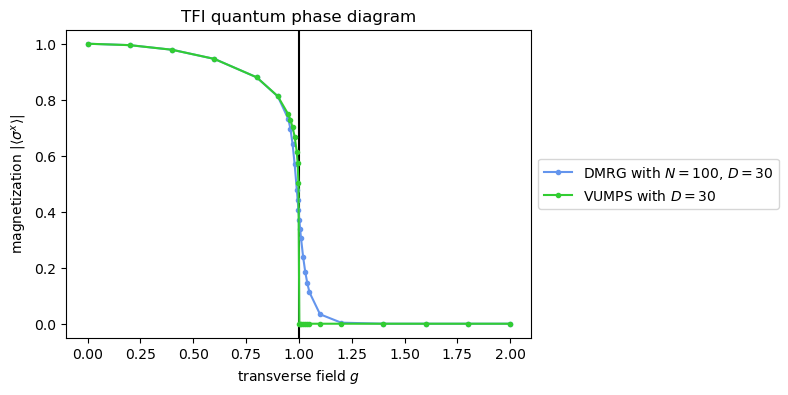

In [5]:
plt.figure(figsize=(6, 4))
plt.title(f"TFI quantum phase diagram")
plt.axvline(x=1.0, color="black")
plt.plot(gs, np.abs(mxs_finite), ".-", color="cornflowerblue", \
         label=f"DMRG with $N = {N}$, $D = {D}$")
plt.plot(gs, np.abs(mxs_infinite), ".-", color="limegreen", label=f"VUMPS with $D = {D}$")
plt.xlabel(r"transverse field $g$")
plt.ylabel(r"magnetization $\vert \langle \sigma^x \rangle \vert$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 2) Excitations

### 2.1) Infinite uniform MPS: Variational perturbations in plane wave superposition

In [6]:
def get_infinite_tfi_excitation_dispersion(g, D):
    """For the TFI model on an infinite chain with transverse field g, find the ground state with 
    VUMPS and variational plane wave excitations on top, using a bond dimension D."""
    tfi_model_infinite = TFIModelInfinite(g)
    # exact analytical solution
    ps_exact, es_exact = tfi_model_infinite.get_exact_excitation_dispersion()
    # vumps and variational plane wave excitations
    h = tfi_model_infinite.get_h()
    _, umps0, _,  = get_infinite_tfi_gs(g, D)
    ps = list(np.arange(-np.pi, 0, np.pi/10)) + [0] + list(np.arange(0, np.pi + np.pi/10, np.pi/10))
    # paramagnetic phase (single spin flip excitations) and critical point (gapless excitation)
    if g >= 1.:  
        es = []
        for p in ps:
            excitation_engine = VariationalPlaneWaveExcitationEngine(umps0, h, p, k=1, tol=1.e-10)
            e, _ = excitation_engine.run()
            es.append(e)
        return ps_exact, es_exact, ps, es
    elif 0 <= g < 1:  # ferromagnetic phase (topological domain wall excitations)
        mx0 = umps0.get_site_expectation_value(tfi_model_infinite.sigma_x)
        for i in range(100):
            _, umps0_tilde, _,  = get_infinite_tfi_gs(g, D)
            mx0_tilde = umps0_tilde.get_site_expectation_value(tfi_model_infinite.sigma_x)
            if np.abs(mx0 + mx0_tilde) < 1.e-5:
                print(f"Found mx0={mx0} and mx0_tilde={mx0_tilde} after {i+2} ground state searchs.")
                es = []
                for p in ps:
                    excitation_engine = VariationalPlaneWaveExcitationEngine(umps0, h, p, k=1, \
                                                                             tol=1.e-10, \
                                                                             umps0_tilde=umps0_tilde)
                    e, _ = excitation_engine.run()
                    es.append(e)
                return ps_exact, es_exact, ps, es  

In [7]:
D = 10
ps_exact, es_exact_para, ps, es_para = get_infinite_tfi_excitation_dispersion(g=1.5, D=D)
_, es_exact_crit, _, es_crit = get_infinite_tfi_excitation_dispersion(g=1., D=D)
_, es_exact_ferro, _, es_ferro = get_infinite_tfi_excitation_dispersion(g=0.5, D=D)

g = 1.5, D = 10:
AL, L: Converged up to tol=1e-10. Final error after 6 iterations: 1.9796056654806765e-12.
AR, R: Converged up to tol=1e-10. Final error after 6 iterations: 9.424610570845716e-14.
uMPS ground state converged with VUMPS up to tol=1e-10 in gradient norm. Final error after 11 iterations: 3.3018732821657984e-11.
Ground state energy density: -1.671926221535689. 
Ground state variance density: (2.8401517249143637e-12+3.0921445959286586e-16j).
|e0 - e0_exact| = 5.062616992290714e-13.
Magnetization densities: 8.490430580820885e-14 (X) and 0.8773282152523014 (Z).
g = 1.0, D = 10:
AL, L: Converged up to tol=1e-10. Final error after 6 iterations: 1.2343435233645922e-14.
AR, R: Converged up to tol=1e-10. Final error after 6 iterations: 9.005148724844965e-16.
uMPS ground state converged with VUMPS up to tol=1e-10 in gradient norm. Final error after 86 iterations: 8.524685320844953e-11.
Ground state energy density: -1.2732386186007558. 
Ground state variance density: (1.4563432465357

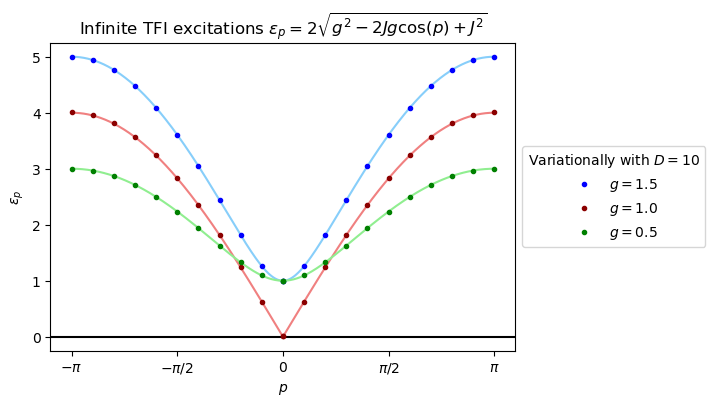

In [8]:
plt.figure(figsize=(6, 4))
plt.title(r"Infinite TFI excitations $\epsilon_p = 2 \sqrt{g^2 - 2Jg\cos(p) + J^2}$")
plt.xticks(np.arange(-np.pi, 3*np.pi/2, np.pi/2), \
           [r"$-\pi$",r"$-\pi /2$", r"$0$", r"$\pi /2$",r"$\pi$"])
plt.axhline(y=0., color="black")
plt.plot(ps_exact, es_exact_para, color="lightskyblue")
plt.plot(ps, es_para, ".", color="blue", label=r"$g = 1.5$")
plt.plot(ps_exact, es_exact_crit, color="lightcoral")
plt.plot(ps, es_crit, ".", color="darkred", label=r"$g = 1.0$")
plt.plot(ps_exact, es_exact_ferro, color="lightgreen")
plt.plot(ps, es_ferro, ".", color="green", label=r"$g = 0.5$")
plt.xlabel(r"$p$")
plt.ylabel(r"$\epsilon_p$")
plt.legend(title=f"Variationally with $D = {D}$", loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 2.2) Finite MPS: Variational site dependent perturbations

* Dispersion relation for periodic MPO

In [9]:
def get_degeneracies(Es, psis, tol):
    """For a list Es of eigenvalues and a list psis of corresponding eigenvector, find degeneracies
    up to tolerance tol."""
    k = len(Es)
    H_deg = {}
    for i in range(k):
        E_i = Es[i]
        psi_i = psis[i]
        contained_i = False
        for E in H_deg:
            if np.allclose(E_i, E, rtol=tol, atol=0):
                H_deg[E].append(psi_i)
                contained_i = True
                break
        if not contained_i:
            H_deg[E_i] = [psi_i]
    return H_deg

def diagonalize_translation_operator(H_deg, get_translation_overlap):
    """For H_deg a dictionary with eigenenergies as keys and degenerate eigenvectors as values,
    build the translation matrix with get_translation_overlap and diagonalize it."""
    tdispersion = []
    for E in H_deg:
        psis = H_deg[E]
        l = len(psis)
        T_E = np.zeros((l, l))
        for i in range(l):
            for j in range(l):
                T_E[i, j] = get_translation_overlap(psis[j], psis[i])
        ts, phis = np.linalg.eig(T_E)
        for t in ts:
            tdispersion.append([t, E])
    return tdispersion

def get_finite_tfi_excitation_dispersion(N, g, D_max, k):
    """For the TFI model on a finite chain of length N with periodic boundary conditions and 
    transverse field g, find the ground state with DMRG and k momentum resolved variational 
    quasiparticle excitations on top, using a maximal bond dimension D_max."""
    tfi_model_finite = TFIModelFinite(N, g)
    # exact analytical single particle excitations
    ps_exact, Es_exact = tfi_model_finite.get_exact_excitation_dispersion()
    # energy ground state with dmrg
    E0, mps0, _ = get_finite_tfi_gs(N, g, D_max, bc="periodic")
    # energy excitations and degeneracies
    mpo = tfi_model_finite.get_mpo(bc="periodic")
    excitation_engine = VariationalQuasiparticleExcitationEngine(mps0, mpo, k)
    Es_excited, empss = excitation_engine.run()
    H_deg = get_degeneracies(Es_excited, empss, tol=1.e-3)
    # translation diagonalization
    t0 = get_translation_overlap(mps0.ARs, mps0.ARs)
    p0 = N/(2 * np.pi) * np.angle(t0)
    dispersion = [[p0, 0.]]
    tdispersion_excited = diagonalize_translation_operator(H_deg, get_emps_translation_overlap)
    for tE in tdispersion_excited:
        p = N/(2 * np.pi) * np.angle(tE[0])
        E = tE[1]
        dispersion.append([p, E - E0])
    dispersion = np.array(dispersion)
    ps = dispersion[:, 0]
    Es = dispersion[:, 1]
    ind_sort = np.argsort(Es)
    ps = ps[ind_sort]
    Es = Es[ind_sort]
    print(f"Found {k} momentum resolved variational quasiparticle excitations.")
    return ps_exact, Es_exact, ps, Es

def get_finite_tfi_excitation_dispersion_ed(N, g, k):
    """For the TFI model on a finite chain of length N with periodic boundary conditions and 
    transverse field g, find the ground state and k momentum resolved excitations with exact 
    diagonalization."""
    print(f"N = {N}, g = {g}:")
    tfi_model_finite = TFIModelFinite(N, g)
    # exact analytical single particle excitations
    ps_exact, Es_exact = tfi_model_finite.get_exact_excitation_dispersion()
    # energy diagonalization and degeneracies
    H = tfi_model_finite.get_H(bc="periodic")
    Es, psis = sparse.linalg.eigsh(H, k=k+1, which="SA")
    E0 = Es[0]
    psis_list = []
    for i in range(k+1):
        psis_list.append(psis[:, i])
    H_deg = get_degeneracies(Es, psis_list, tol=1.e-3)
    # translation diagonalization
    T = tfi_model_finite.get_T()
    def get_translation_overlap(psi, phi):
        return np.inner(np.conj(phi), T @ psi)
    tdispersion = diagonalize_translation_operator(H_deg, get_translation_overlap)
    tdispersion = np.array(tdispersion)
    ps = N/(2 * np.pi) * np.angle(tdispersion[:, 0])
    Es = tdispersion[:, 1] - E0
    ind_sort = np.argsort(Es)
    ps = ps[ind_sort]
    Es = Es[ind_sort]
    print(f"Found {k+1} momentum resolved eigenstates with exact diagonalization.")
    return ps_exact, Es_exact, ps, Es

small N: comparison with exact diagonalization

In [10]:
N = 10
D = 30

N = 10, g = 1.5, D_max = 30:
MPS ground state converged with DMRG up to tol=1e-10 in energy difference. Final error after 4 iterations: 7.105427357601002e-15.
Ground state energy: -16.723024913948443. 
Ground state variance: -1.7053025658242404e-13. 
Bond dimensions: [1, 2, 4, 8, 16, 30, 16, 8, 4, 2, 1].
|E0 - E0_exact| = 0.007569844111468882.
Mean magnetizations: -2.474632950714926e-16 (X) and 0.8752422808593879 (Z).
Found 50 momentum resolved variational quasiparticle excitations.
N = 10, g = 1.5:
Found 51 momentum resolved eigenstates with exact diagonalization.


/Users/lukas/micromamba/envs/masterthesis_env/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/lukas/micromamba/envs/masterthesis_env/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


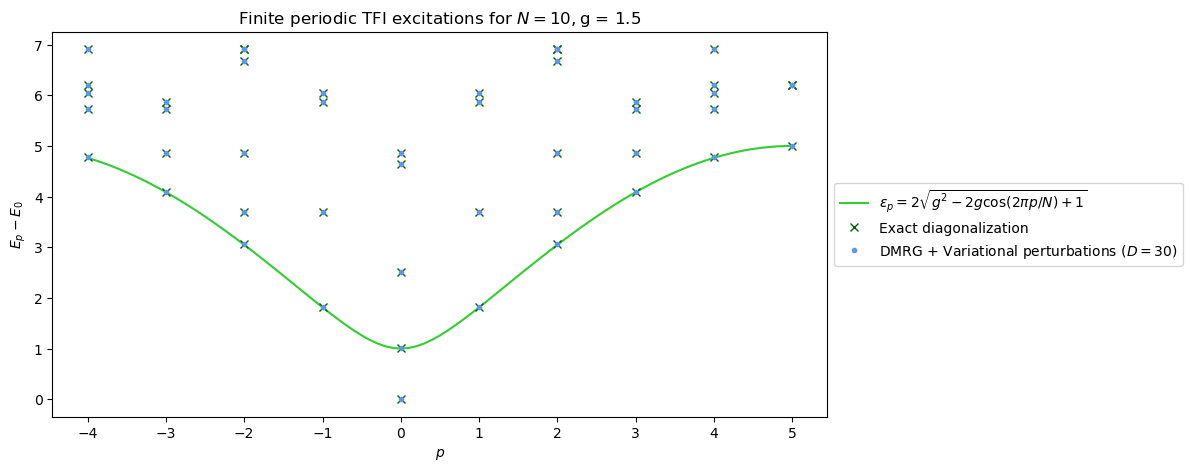

In [11]:
g = 1.5

ps_exact, Es_exact, ps_mps, Es_mps = get_finite_tfi_excitation_dispersion(N, g, D, k=5*N)
_, _, ps_ed, Es_ed = get_finite_tfi_excitation_dispersion_ed(N, g, k=5*N)

plt.figure(figsize=(10, 5))
plt.title(f"Finite periodic TFI excitations for $N = {N}, $g = {g}")
plt.xticks(TFIModelFinite(N, g).get_ps())
plt.plot(ps_exact, Es_exact, "-", color="limegreen", \
         label=r"$\epsilon_p = 2 \sqrt{g^2 - 2g\cos(2\pi p/N) + 1}$")
plt.plot(ps_ed[:-5], Es_ed[:-5], "x", color="darkgreen", label="Exact diagonalization")
plt.plot(ps_mps[:-5], Es_mps[:-5], ".", color="cornflowerblue", \
         label=f"DMRG + Variational perturbations ($D = {D}$)")
plt.xlabel(r"$p$")
plt.ylabel(r"$E_p - E_0$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

N = 10, g = 1.0, D_max = 30:
MPS ground state converged with DMRG up to tol=1e-10 in energy difference. Final error after 4 iterations: 7.105427357601002e-15.
Ground state energy: -12.784906442999318. 
Ground state variance: 1.4210854715202004e-13. 
Bond dimensions: [1, 2, 4, 8, 16, 30, 16, 8, 4, 2, 1].
|E0 - E0_exact| = 0.15740341364923083.
Mean magnetizations: 4.960083100719576e-15 (X) and 0.639245322149967 (Z).
Found 50 momentum resolved variational quasiparticle excitations.
N = 10, g = 1.0:
Found 51 momentum resolved eigenstates with exact diagonalization.


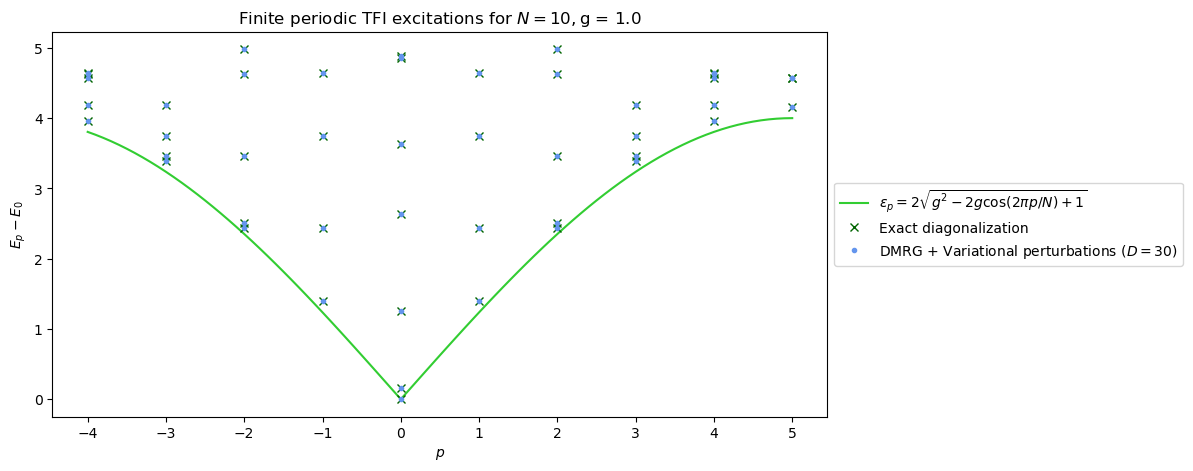

In [12]:
g = 1.

ps_exact, Es_exact, ps_mps, Es_mps = get_finite_tfi_excitation_dispersion(N, g, D, k=5*N)
_, _, ps_ed, Es_ed = get_finite_tfi_excitation_dispersion_ed(N, g, k=5*N)

plt.figure(figsize=(10, 5))
plt.title(f"Finite periodic TFI excitations for $N = {N}, $g = {g}")
plt.xticks(TFIModelFinite(N, g).get_ps())
plt.plot(ps_exact, Es_exact, "-", color="limegreen", \
         label=r"$\epsilon_p = 2 \sqrt{g^2 - 2g\cos(2\pi p/N) + 1}$")
plt.plot(ps_ed[:-5], Es_ed[:-5], "x", color="darkgreen", label="Exact diagonalization")
plt.plot(ps_mps[:-5], Es_mps[:-5], ".", color="cornflowerblue", \
         label=f"DMRG + Variational perturbations ($D = {D}$)")
plt.xlabel(r"$p$")
plt.ylabel(r"$E_p - E_0$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

N = 10, g = 0.5, D_max = 30:
MPS ground state converged with DMRG up to tol=1e-10 in energy difference. Final error after 4 iterations: 3.552713678800501e-15.
Ground state energy: -10.635604409347954. 
Ground state variance: 1.5631940186722204e-13. 
Bond dimensions: [1, 2, 4, 8, 16, 30, 16, 8, 4, 2, 1].
|E0 - E0_exact| = 0.00032072668066795984.
Mean magnetizations: 8.945414950147498e-12 (X) and 0.2589695682344021 (Z).
Found 50 momentum resolved variational quasiparticle excitations.
N = 10, g = 0.5:
Found 51 momentum resolved eigenstates with exact diagonalization.


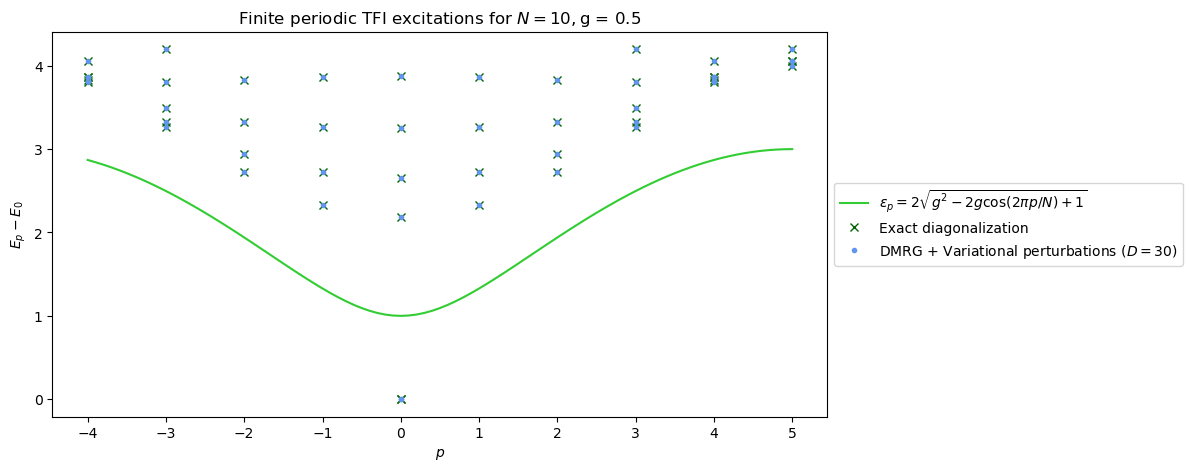

In [13]:
g = 0.5

ps_exact, Es_exact, ps_mps, Es_mps = get_finite_tfi_excitation_dispersion(N, g, D, k=5*N)
_, _, ps_ed, Es_ed = get_finite_tfi_excitation_dispersion_ed(N, g, 5*N)

plt.figure(figsize=(10, 5))
plt.title(f"Finite periodic TFI excitations for $N = {N}, $g = {g}")
plt.xticks(TFIModelFinite(N, g).get_ps())
plt.plot(ps_exact, Es_exact, "-", color="limegreen", \
         label=r"$\epsilon_p = 2 \sqrt{g^2 - 2g\cos(2\pi p/N) + 1}$")
plt.plot(ps_ed[:-5], Es_ed[:-5], "x", color="darkgreen", label="Exact diagonalization")
plt.plot(ps_mps[:-5], Es_mps[:-5], ".", color="cornflowerblue", \
         label=f"DMRG + Variational perturbations ($D = {D}$)")
plt.xlabel(r"$p$")
plt.ylabel(r"$E_p - E_0$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

* Standing wave excitations for open MPO

In [14]:
def get_tfi_standing_wave_excitations(N, g, D_max, k):
    """For the TFI model on a finite chain of length N with open boundary conditions and 
    transverse field g, find the ground state with DMRG and k variational quasiparticle excitations 
    on top, using a maximal bond dimension D_max. Compute the local energies for all states."""
    tfi_model_finite = TFIModelFinite(N, g)
    # ground state with dmrg
    E0, mps0, mx0 = get_finite_tfi_gs(N, g, D_max, bc="open")
    # variational quasiparticle excitations
    mpo = tfi_model_finite.get_mpo(bc="open")
    # paramagnetic phase (single spin flip excitations) and critical point (gapless excitation)
    if g >= 1.:  
        excitation_engine = VariationalQuasiparticleExcitationEngine(mps0, mpo, k)
        Es, empss = excitation_engine.run()
    elif 0 <= g < 1:  # ferromagnetic phase (topological domain wall excitations)
        for i in range(100):
            _, mps0_tilde, mx0_tilde = get_finite_tfi_gs(N, g, D_max, bc="open")
            if np.abs(mx0 + mx0_tilde) < 1.e-3:
                print(f"Found mx0={mx0} and mx0_tilde={mx0_tilde} after {i+2} ground state searchs.")
                excitation_engine = VariationalQuasiparticleExcitationEngine(mps0, mpo, k, \
                                                                             mps0_tilde)
                Es, empss = excitation_engine.run()
                break
    print(f"Found {k} variational quasiparticle excitations. Es - E0 = {Es - E0}.")
    # local energies
    h_bonds = tfi_model_finite.get_h_bonds()
    E_bondss = []
    mpss = []
    E_bondss.append(mps0.get_bond_expectation_values(h_bonds))
    mpss.append(mps0)
    for emps in empss:
        E_bondss.append(emps.get_bond_expectation_values(h_bonds))
        mpss.append(emps)
    return E_bondss, mpss

def get_tfi_standing_wave_excitations_ed(N, g, k):
    """For the TFI model on a finite chain of length N with open boundary conditions and 
    transverse field g, find the ground state and k excitations with exact diagonalization. Compute 
    the local energies for all states."""
    print(f"N = {N}, g = {g}:")
    tfi_model_finite = TFIModelFinite(N, g)
    # exact diagonaization
    H = tfi_model_finite.get_H(bc="open")
    Es, psis = sparse.linalg.eigsh(H, k=k+1, which="SA")
    print(f"Found {k+1} eigenstates with exact diagonalization. Es - E0 = {Es - Es[0]}.")
    # local energies
    H_bonds = tfi_model_finite.get_H_bonds(bc="open")
    E_bondss = []
    psis_list = []
    for i in range(k+1):
        psi_i = psis[:, i]
        psis_list.append(psi_i)
        E_bonds_i = []
        for H_bond in H_bonds:
            E_bonds_i.append(np.inner(np.conj(psi_i), H_bond @ psi_i))
        E_bondss.append(E_bonds_i)
    return E_bondss, psis_list

small N: comparison with exact diagonalization

N = 20, g = 1.5, D_max = 30:
MPS ground state converged with DMRG up to tol=1e-10 in energy difference. Final error after 3 iterations: 2.6147972675971687e-12.
Ground state energy: -33.254516753635365. 
Ground state variance: 6.821210263296962e-13. 
Bond dimensions: [1, 2, 4, 8, 13, 17, 20, 20, 20, 20, 20, 20, 20, 20, 20, 17, 13, 8, 4, 2, 1].
Mean magnetizations: 3.4168056023533926e-16 (X) and 0.8849317206347758 (Z).
Found 3 variational quasiparticle excitations. Es - E0 = [1.05481177 1.20699931 1.42912127].
N = 20, g = 1.5:
Found 4 eigenstates with exact diagonalization. Es - E0 = [0.         1.05481177 1.20699931 1.42912127].


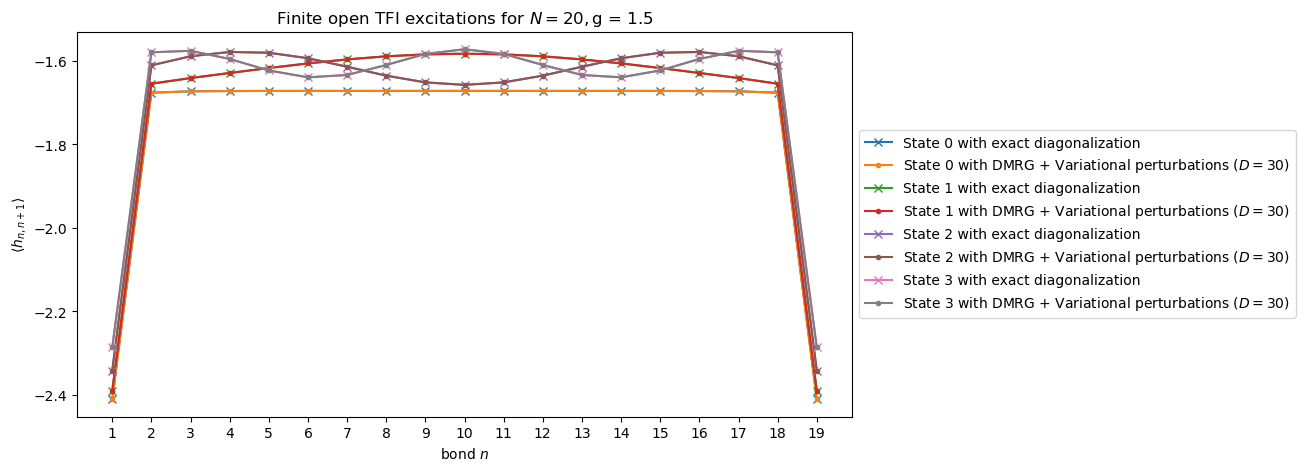

In [15]:
N = 20
D = 30
k = 3
g = 1.5

E_bonds_mps, _ = get_tfi_standing_wave_excitations(N, g, D, k)
E_bonds_ed, _ = get_tfi_standing_wave_excitations_ed(N, g, k)

plt.figure(figsize=(10, 5))
plt.title(f"Finite open TFI excitations for $N = {N}, $g = {g}")
plt.xticks(range(1, N))
for i in range(k+1):
    plt.plot(range(1, N), E_bonds_ed[i], "x-", label=f"State {i} with exact diagonalization")
    plt.plot(range(1, N), E_bonds_mps[i], ".-", \
             label=f"State {i} with DMRG + Variational perturbations ($D = {D}$)")
plt.xlabel(r"bond $n$")
plt.ylabel(r"$\langle h_{n, n+1} \rangle$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

large N

In [16]:
N = 100
D = 30

N = 100, g = 1.5, D_max = 30:
MPS ground state converged with DMRG up to tol=1e-10 in energy difference. Final error after 3 iterations: 6.693312570860144e-11.
Ground state energy: -167.00861447648938. 
Ground state variance: -4.765752237290144e-10. 
Bond dimensions: [1, 2, 4, 8, 13, 17, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 17, 13, 8, 4, 2, 1].
Mean magnetizations: -3.626341107995953e-16 (X) and 0.8788489163351539 (Z).
Found 4 variational quasiparticle excitations. Es - E0 = [1.00278707 1.01110254 1.02481269 1.04370542].


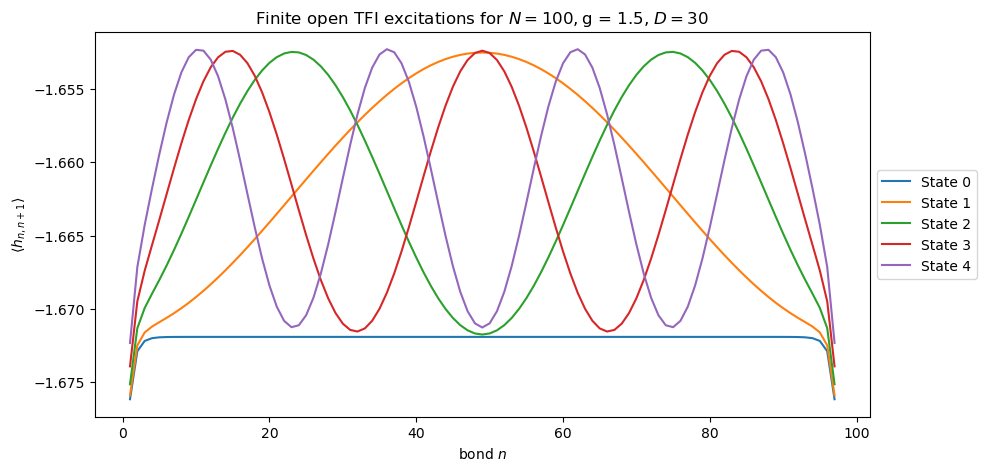

In [17]:
g = 1.5
k = 4

E_bonds_mps, _ = get_tfi_standing_wave_excitations(N, g, D, k)

plt.figure(figsize=(10, 5))
plt.title(f"Finite open TFI excitations for $N = {N}, $g = {g}, $D = {D}$")
for i in range(k+1):
    plt.plot(range(1, N-2), E_bonds_mps[i][1:N-2], "-", label=f"State {i}")
plt.xlabel(r"bond $n$")
plt.ylabel(r"$\langle h_{n, n+1} \rangle$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

N = 100, g = 0.5, D_max = 30:
MPS ground state converged with DMRG up to tol=1e-10 in energy difference. Final error after 3 iterations: 4.590106073010247e-12.
Ground state energy: -105.4837699496428. 
Ground state variance: -5.820766091346741e-11. 
Bond dimensions: [1, 2, 4, 8, 11, 12, 13, 14, 13, 13, 12, 12, 12, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13, 12, 11, 8, 4, 2, 1].
Mean magnetizations: 0.9622412536342203 (X) and 0.2640238146471054 (Z).
N = 100, g = 0.5, D_max = 30:
MPS ground state converged with DMRG up to tol=1e-10 in energy difference. Final error after 3 iterations: 4.590106073010247e-12.
Ground state energy: -105.4837699496428. 
Ground state variance: -5.820766091346741e-11. 
Bond dimensio

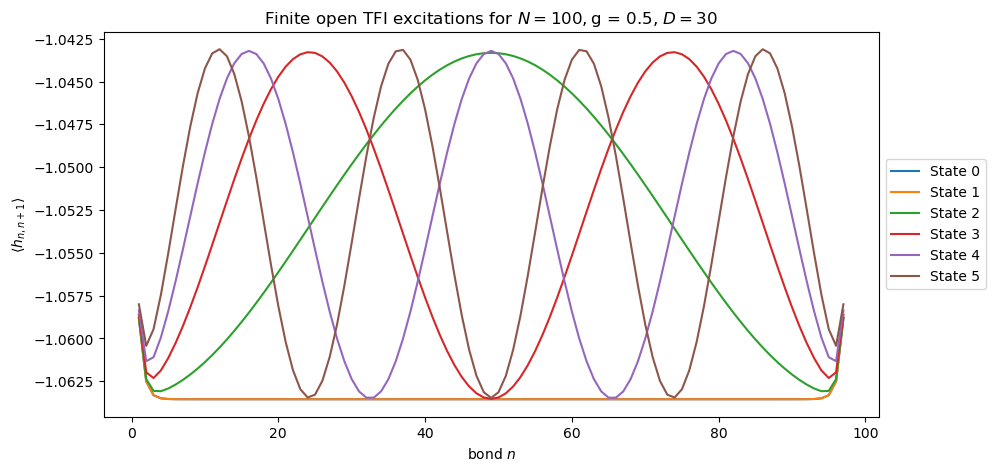

In [18]:
g = 0.5
k = 5

E_bonds_mps, mpss = get_tfi_standing_wave_excitations(N, g, D, k)

plt.figure(figsize=(10, 5))
plt.title(f"Finite open TFI excitations for $N = {N}, $g = {g}, $D = {D}$")
for i in range(k+1):
    plt.plot(range(1, N-2), E_bonds_mps[i][1:N-2], "-", label=f"State {i}")
plt.xlabel(r"bond $n$")
plt.ylabel(r"$\langle h_{n, n+1} \rangle$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()